In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from keras import Sequential
from sklearn.preprocessing import RobustScaler

%matplotlib inline

Using TensorFlow backend.
/Users/davidrobison/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
df = pd.read_csv("data_train.csv").dropna(1, thresh= 247466).dropna(0, how="any").drop(["HOSPID", "KEY", "ATYPE", "TOTCHG", "ASOURCE", "ZIPINC_QRTL"], axis=1)

# Exploratory Data Analysis of Continuous Variables

#### Total Discharges

The median value of total annual discharges from hospitals where the patient was hispanic is considerably higher at 28,621 and for "Native American" considerably lower at 14,607. These could be possible factor variables to explicitly create. 

RACE
0    20118
1    22819
2    28621
3    21113
4    14607
5    24281
Name: TOTAL_DISC, dtype: int64


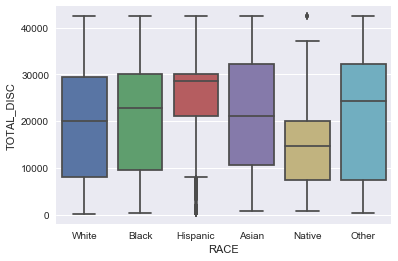

In [6]:
print(df.groupby("RACE")["TOTAL_DISC"].median())
ax = sb.boxplot(x = df.RACE, y=df.TOTAL_DISC, data = df)
ax.set_xticklabels(labels = ["White", "Black", "Hispanic", "Asian",  "Native", "Other"])

## Length of Stay 

Caucasians have a mean length of stay that is lower than other races.  We also see many outliers not shown here.

MEDIAN: RACE
0    4.0
1    5.0
2    5.0
3    5.0
4    4.0
5    5.0
Name: LOS, dtype: float64
MEAN: RACE
0    6.690334
1    8.276655
2    8.501950
3    7.731031
4    7.126761
5    8.934052
Name: LOS, dtype: float64


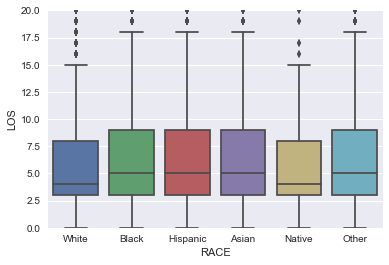

In [7]:
print("MEDIAN:",df.groupby("RACE")["LOS"].median())
print("MEAN:",df.groupby("RACE")["LOS"].mean())
ax = sb.boxplot(x = df.RACE, y=df.LOS, data = df)
plt.ylim(0,20)
ax.set_xticklabels(labels = ["White", "Black", "Hispanic", "Asian", "Native", "Other"])

## Age

The mean age of Caucasians is considerably higher. We could potentially make a variable here, but it could lead to overfitting since causian is already a majority class. 

RACE
0    65.400461
1    56.876192
2    54.395125
3    59.732163
4    56.694836
5    54.940672
Name: AGE, dtype: float64


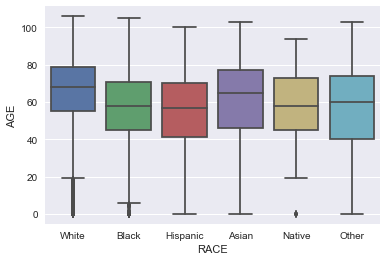

In [8]:
print(df.groupby("RACE")["AGE"].mean())
ax = sb.boxplot(x = df.RACE, y = df.AGE)
ax.set_xticklabels(labels = ["White", "Black", "Hispanic", "Asian", "Native", "Other"])

## PRDAY 1: Days Post Operation until Discharge

The distribution is about the same here, but there are many outliers in most of the races

RACE
0    0.0
1    1.0
2    0.0
3    1.0
4    0.0
5    0.0
Name: PRDAY1, dtype: float64
RACE
0    1.652166
1    2.127842
2    2.164789
3    2.142129
4    1.356808
5    2.006129
Name: PRDAY1, dtype: float64


(-4, 6)

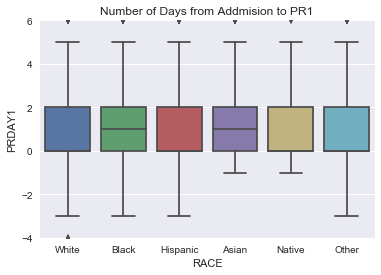

In [22]:
continuous = ["AGE", "LOS", "PRDAY1", "TOTAL_DISC"]
print(df.groupby("RACE")["PRDAY1"].median())
print(df.groupby("RACE")["PRDAY1"].mean())
ax = sb.boxplot(x = df.RACE, y = df.PRDAY1)
ax.set_xticklabels(labels = ["White", "Black", "Hispanic", "Asian", "Native", "Other"])
plt.title("Number of Days from Addmision to PR1")
plt.ylim(-4,6)

## NPR: Number of Procedures on Record

NPR Mean: RACE
0    3.099012
1    2.631939
2    3.577356
3    3.082106
4    2.849765
5    3.038735
Name: NPR, dtype: float64
NPR Median: RACE
0    3.099012
1    2.631939
2    3.577356
3    3.082106
4    2.849765
5    3.038735
Name: NPR, dtype: float64


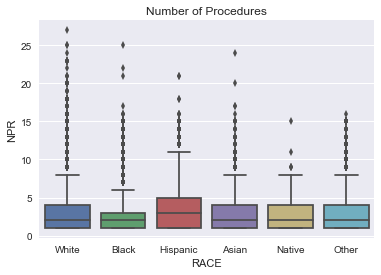

In [23]:
print("NPR Mean:", df.groupby("RACE")["NPR"].mean())
print("NPR Median:", df.groupby("RACE")["NPR"].mean())

ax = sb.boxplot(x=df.RACE, y = df.NPR)
ax.set_xticklabels(labels = ["White", "Black", "Hispanic", "Asian",  "Native", "Other"])
plt.title("Number of Procedures")
plt.ylim

## NDX: Number of Diagnoses on Record

Causcasian have a higher median number of diagnoses and hispanic have lower at 11

NDX Median: RACE
0    13
1    12
2    11
3    12
4    12
5    12
Name: NDX, dtype: int64


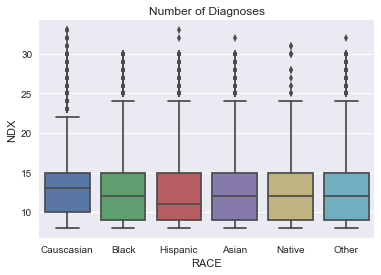

In [11]:
print("NDX Median:", df.groupby("RACE")["NDX"].median())
ax = sb.boxplot(df.RACE, df.NDX)
ax.set_xticklabels(labels = ["Causcasian", "Black", "Hispanic", "Asian",  "Native", "Other"])
plt.title("Number of Diagnoses")

## Label Encoding to Turn Categorical Variables to Labels

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [4]:
df.columns[df.columns != "RACE"]

Index(['AGE', 'AMONTH', 'AWEEKEND', 'DIED', 'DISCWT', 'DISPUNIFORM', 'DQTR',
       'DXCCS1', 'DXCCS2', 'DXCCS3', 'DXCCS4', 'DXCCS5', 'DXCCS6', 'DXCCS7',
       'DXCCS8', 'FEMALE', 'LOS', 'MDC', 'NDX', 'NIS_STRATUM', 'NPR', 'ORPROC',
       'PAY1', 'PRCCS1', 'PRDAY1', 'HOSP_BEDSIZE', 'HOSP_CONTROL',
       'HOSP_LOCTEACH', 'HOSP_REGION', 'TOTAL_DISC', 'CM_AIDS', 'CM_ALCOHOL',
       'CM_ANEMDEF', 'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG',
       'CM_COAG', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C',
       'CM_HYPOTHY', 'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO',
       'CM_OBESE', 'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC',
       'CM_RENLFAIL', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS'],
      dtype='object')

In [5]:
#call label class on columns to generate label for 
df = MultiColumnLabelEncoder(columns= ['AMONTH', "NIS_STRATUM", 'AWEEKEND', 'DIED', "DISCWT",
       'DISPUNIFORM', 'DQTR', 'DXCCS1', 'DXCCS2', 'DXCCS3', 'DXCCS4', 'DXCCS5',
       'DXCCS6', 'DXCCS7', 'DXCCS8', 'FEMALE', 'MDC',
       'ORPROC', 'PAY1', 'PRCCS1', 'RACE',
       'HOSP_BEDSIZE', 'HOSP_CONTROL', 'HOSP_LOCTEACH', 'HOSP_REGION']).fit_transform(df)

## Create Dataframes of All Boolean Variables and Create Dummy Variables for Labeled Data

In [6]:
#get bool_cols; we'll keep these as is
bool_cols_to_keep = [col for col in df.columns if df[col].value_counts().index.isin([0,1]).all()]
bool_cols = df[bool_cols_to_keep]

#truly continuous data; we get this from the documentation
columns_to_scale = ['AGE', 'DISCWT', 'TOTAL_DISC', 'LOS', 'NDX', 'NPR']
dfNumeric = df[columns_to_scale]

#also need to hold out the outcome var
outcome_var = ['RACE']
outcome_col = df[outcome_var]

#everything else should be made dummies
columns_to_encode = [col for col in df.columns if col not in columns_to_scale + bool_cols_to_keep + outcome_var]

#we can use pandas get dummies for one-hot encoding but we need make all categorical data a string firstumpy 
#lastly turn into numpy array
dummy_cols = pd.get_dummies(df[columns_to_encode].astype(str))

## Concatenate Dataframes back together

In [7]:
df_sparse = pd.concat([dfNumeric, dummy_cols, bool_cols, pd.DataFrame(outcome_col, columns= ["RACE"])], axis = 1)
print(df_sparse.columns)
print(df_sparse.shape)

Index(['AGE', 'DISCWT', 'TOTAL_DISC', 'LOS', 'NDX', 'NPR', 'AMONTH_0',
       'AMONTH_1', 'AMONTH_10', 'AMONTH_11',
       ...
       'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL',
       'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS', 'RACE'],
      dtype='object', length=2547)
(152867, 2547)


In [8]:
X = np.array(df_sparse.iloc[:,df_sparse.columns != "RACE"])
y = df_sparse["RACE"]
print(X.shape)

(152867, 2546)


## Train Test Split

In [9]:
np.random.seed(0)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 12)

## Scale Continuous Variables in Train and Test Set

Using robust scaler to account for the many outlier variables observed during EDA. StandardScaler scales by removing the mean and scaling to unit variance. However, outliers can influence the sample mean / variance in a negative way. In such cases, the median and the interquartile range often give better results. See here: http://scikit-learn.org/0.18/auto_examples/preprocessing/plot_robust_scaling.html

In [10]:
#The first 6 features of the train and test set are our continuous features: 
#['AGE', 'DISCWT', 'TOTAL_DISC', 'LOS', 'NDX', 'NPR']

X_train_contScale = X_train[:,0:6]
X_test_contScale= X_test[:,0:6]

robustScale = RobustScaler(copy=False)

dfNumericTrain = robustScale.fit(X_train_contScale).transform(X_train_contScale)
dfNumericTest = robustScale.transform(X_test_contScale)

X_trainFinal = np.hstack([dfNumericTrain, X_train[:,6:]])
X_testFinal = np.hstack([dfNumericTest, X_test[:,6:]])
print(X_trainFinal.shape, X_testFinal.shape)

(102420, 2546) (50447, 2546)


In [53]:
dfNumericTrain.shape

array([[-0.88461538, -0.15789474, -0.25662188, -0.6       , -0.5       ,
         0.66666667],
       [-0.03846154, -0.52631579, -0.62984645,  1.8       ,  0.5       ,
         1.33333333],
       [ 0.        , -0.78947368, -0.96924184,  1.6       ,  0.33333333,
         0.66666667],
       ..., 
       [ 0.42307692, -0.57894737,  0.79596929, -0.2       ,  0.33333333,
         0.33333333],
       [-1.03846154,  0.26315789, -0.63459693,  0.2       ,  1.        ,
        -0.33333333],
       [ 0.        , -1.15789474, -0.75014395,  0.6       ,  0.83333333,
        -0.33333333]])

#### Save Robust Scaler for Later Use with Validation Set

In [106]:
from sklearn.externals import joblib
import pickle
joblib.dump(robustScale, "robustScaler")
pickle.dump(robustScale, open("robustScaler1", 'wb'))

## Train Keras Multi-Layer Perpcetron Model

### Build Neural Network Architecture

#### Compile Neural Network

In [11]:
from keras import models
from keras import layers

network = models.Sequential()

#add first layer
network.add(layers.Dense(units=500, activation='relu', input_dim = 2546))

#output layer; we use softmax to ensure values between 0 and 1 and can be interpreted as predicted probabilities
network.add(layers.Dense(units = 6, activation='softmax')) #output layer must create one output for each class (6)

network.compile(loss='categorical_crossentropy', # Categorical cross-entropy for multi class output
                optimizer='adam',
                metrics=['categorical_accuracy']) 

#### 2.3 Train Neural Network

#### Run Training

In [101]:
#set seed
np.random.seed(0)

from keras.utils.np_utils import to_categorical

y_cat_train = to_categorical(y_train)

network.fit(X_trainFinal, y_cat_train, epochs=25, batch_size = 10242) #75 iterations

In [13]:
y_test_cat = to_categorical(y_test)

score = network.evaluate(X_testFinal, y_test_cat, batch_size=5000)

50447/50447 [==============================] - 5s 96us/step


#### Report Results

In [14]:
print(network.metrics_names)
print(score)

['loss', 'categorical_accuracy']
[0.63262013158758146, 0.78395147231047335]


In [15]:
predictions = network.predict_classes(X_testFinal)

50447/50447 [==============================] - 8s 157us/step

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

report = classification_report(y_test, predictions)
print(report)
print(accuracy_score(y_test, predictions))

             precision    recall  f1-score   support

          0       0.82      0.95      0.88     37485
          1       0.57      0.41      0.47      7858
          2       0.42      0.17      0.24      3072
          3       0.00      0.00      0.00       580
          4       0.00      0.00      0.00        57
          5       0.61      0.11      0.19      1395

avg / total       0.74      0.78      0.75     50447

0.783951473824


/Users/davidrobison/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [88]:
#Save the model
network.save("best_model.e50_u500_adam.h5")

In [71]:
print(confusion_matrix(y_test, predictions))

[[35674  1501   270     3     0    37]
 [ 4226  3238   366     2     0    26]
 [ 1928   612   506     1     0    25]
 [  446   107    21     1     0     5]
 [   54     2     1     0     0     0]
 [  920   247    73     1     0   154]]


## Network 2 With SGD and Categorical Cross Entropy

In [24]:
network2 = models.Sequential()

#add first layer
network2.add(layers.Dense(units=500, activation='relu', input_dim = 2546))

#output layer; we use softmax to ensure values between 0 and 1 and can be interpreted as predicted probabilities
network2.add(layers.Dense(units = 6, activation='softmax')) #output layer must create one output for each class (6)

network2.compile(loss='categorical_crossentropy', # Categorical cross-entropy for multi class output
                optimizer='sgd',
                metrics=['categorical_accuracy']) 

network2.fit(X_train, y_cat_train, epochs=50, batch_size = 10242) #75 iterations

In [85]:
print(network2.metrics_names)
network2.evaluate(X_test, y_test_cat, batch_size=5000)

['loss', 'categorical_accuracy']
50447/50447 [==============================] - 4s 85us/step


[0.77557514760884938, 0.74408785040570879]

It looks like SGD and gradient descent is not useful here, this only predict class 0 and 1

In [87]:
predictions2 = network2.predict_classes(X_test)
print(classification_report(y_test, predictions2))

50447/50447 [==============================] - 7s 147us/step

/Users/davidrobison/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Grid Search First Layer - 300,500,700,900,1100

In [107]:
from keras.layers import Dropout

nodes = [300,500,700,900,1100]
modelPredictions = [1,2,3,4,5]


# multi_network.add(layers.Dense(units=500, activation='relu', input_dim = 2546))

for nodeCount in range(0,len(nodes)):
    multiNet = models.Sequential()
    multiNet.add(layers.Dense(units = nodes[nodeCount], activation = "relu", input_dim = 2546))
    multiNet.add(layers.Dense(units = 6, activation = "softmax"))
    
    multiNet.compile(loss='categorical_crossentropy', # Categorical cross-entropy for multi class output
                optimizer='adam',
                metrics=['categorical_accuracy']) 
    multiNet.fit(X_trainFinal, y_cat_train, epochs = 25, batch_size = 10242)
    
    multiNet.evaluate(X_testFinal, y_test_cat)
    predictionsMultiNet = multiNet.predict_classes(X_testFinal)
    
    modelPredictions[nodeCount] = predictionsMultiNet

In [32]:
for prediction in range(0,len(modelPredictions)):
    print(accuracy_score(modelPredictions[prediction], y_test))
    print(classification_report(modelPredictions[prediction], y_test))
    
firstLayer = pd.DataFrame(data={"300_Nodes":modelPredictions[0].ravel(), "500_Nodes":modelPredictions[1].ravel(), 
                                  "700_Nodes":modelPredictions[2].ravel(), "900_Nodes":modelPredictions[3].ravel(), 
                              "1100_Nodes":modelPredictions[4].ravel()})
firstLayer.to_csv("gridSearchPredictions_firstLayer.csv")

0.783872182687
             precision    recall  f1-score   support

          0       0.95      0.82      0.88     43354
          1       0.41      0.56      0.47      5677
          2       0.16      0.42      0.23      1174
          3       0.00      0.00      0.00         1
          4       0.00      0.00      0.00         0
          5       0.11      0.62      0.18       241

avg / total       0.87      0.78      0.82     50447

0.782167423236
             precision    recall  f1-score   support

          0       0.94      0.83      0.88     42723
          1       0.44      0.55      0.49      6274
          2       0.17      0.42      0.24      1205
          3       0.00      0.00      0.00         3
          4       0.00      0.00      0.00         0
          5       0.11      0.62      0.18       242

avg / total       0.86      0.78      0.81     50447

0.784328106726
             precision    recall  f1-score   support

          0       0.95      0.83      0.88     

/Users/davidrobison/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


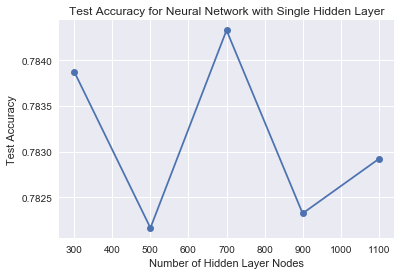

In [41]:
nodes = [300,500,700,900,1100]
nodeAccuray = []
for prediction in range(0,len(modelPredictions)):
    nodeAccuray.append(accuracy_score(modelPredictions[prediction], y_test))

ax5 = plt.plot(nodes, nodeAccuray, marker = "o")
plt.title("Test Accuracy for Neural Network with Single Hidden Layer")
plt.ylabel("Test Accuracy")
plt.xlabel("Number of Hidden Layer Nodes")
plt.savefig("Single Layer Test Accuracy.png")

## Grid search second hidden layer

In [40]:
nodes = [350,450, 550, 650, 700]
modelPredictions = [1,2,3,4,5]


# multi_network.add(layers.Dense(units=500, activation='relu', input_dim = 2546))

for nodeCount in range(0,len(nodes)):
    multiNet = models.Sequential()
    multiNet.add(layers.Dense(units = 700, activation = "relu", input_dim = 2546))
    multiNet.add(layers.Dense(units = nodes[nodeCount], activation = "relu"))
    multiNet.add(layers.Dense(units = 6, activation = "softmax"))
    
    multiNet.compile(loss='categorical_crossentropy', # Categorical cross-entropy for multi class output
                optimizer='adam',
                metrics=['categorical_accuracy']) 
    multiNet.fit(X_trainFinal, y_cat_train, epochs = 25, batch_size = 10242)
    
    multiNet.evaluate(X_testFinal, y_test_cat)
    predictionsMultiNet = multiNet.predict_classes(X_testFinal)
    
    modelPredictions[nodeCount] = predictionsMultiNet

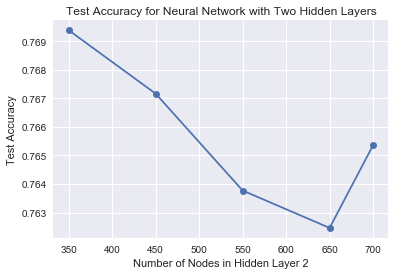

In [44]:
nodes = [350,450, 550, 650, 700]
nodeAccuray = []
for prediction in range(0,len(modelPredictions)):
    nodeAccuray.append(accuracy_score(modelPredictions[prediction], y_test))

ax6 = plt.plot(nodes, nodeAccuray, marker = "o")
plt.title("Test Accuracy for Neural Network with Two Hidden Layers")
plt.ylabel("Test Accuracy")
plt.xlabel("Number of Nodes in Hidden Layer 2")
plt.savefig("Multi Layer Test Accuracy.png")

In [46]:
for prediction in range(0,len(modelPredictions)):
    print(accuracy_score(modelPredictions[prediction], y_test))
    print(classification_report(modelPredictions[prediction], y_test))
    
secondLayer = pd.DataFrame(data={"350_Nodes":modelPredictions[0].ravel(), "450_Nodes":modelPredictions[1].ravel(), 
                                  "550_Nodes":modelPredictions[2].ravel(), "650_Nodes":modelPredictions[3].ravel(), 
                              "700":modelPredictions[4].ravel()})
secondLayer.to_csv("gridSearchPredictions_secondLayer.csv")

0.769381727357
             precision    recall  f1-score   support

          0       0.93      0.83      0.88     41932
          1       0.40      0.52      0.46      6072
          2       0.21      0.38      0.27      1695
          3       0.03      0.10      0.05       183
          4       0.00      0.00      0.00         0
          5       0.15      0.36      0.21       565

avg / total       0.83      0.77      0.79     50447

0.767161575515
             precision    recall  f1-score   support

          0       0.92      0.83      0.87     41585
          1       0.41      0.52      0.46      6194
          2       0.23      0.34      0.27      2040
          3       0.02      0.08      0.03       119
          4       0.00      0.00      0.00         0
          5       0.15      0.40      0.21       509

avg / total       0.82      0.77      0.79     50447

0.763771879398
             precision    recall  f1-score   support

          0       0.92      0.83      0.87     

/Users/davidrobison/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [47]:
print(confusion_matrix(modelPredictions[1], y_test))

[[34564  3970  1749   424    48   830]
 [ 2073  3228   558    99     4   232]
 [  649   538   695    34     5   119]
 [   51    33    15    10     0    10]
 [    0     0     0     0     0     0]
 [  148    89    55    13     0   204]]


## Grid Search Drop Out

In [48]:
dropOut = [0.1, 0.2, 0.3, 0.4, 0.5]
modelPredictions = [1,2,3,4,5]


# multi_network.add(layers.Dense(units=500, activation='relu', input_dim = 2546))

for nodeCount in range(0,len(dropOut)):
    multiNet = models.Sequential()
    multiNet.add(layers.Dense(units = 700, activation = "relu", input_dim = 2546))
    multiNet.add(Dropout(rate=dropOut[nodeCount]))
    multiNet.add(layers.Dense(units = 350, activation = "relu"))
    multiNet.add(layers.Dense(units = 6, activation = "softmax"))
    
    multiNet.compile(loss='categorical_crossentropy', # Categorical cross-entropy for multi class output
                optimizer='adam',
                metrics=['categorical_accuracy']) 
    multiNet.fit(X_trainFinal, y_cat_train, epochs = 25, batch_size = 10242)
    
    multiNet.evaluate(X_testFinal, y_test_cat)
    predictionsMultiNet = multiNet.predict_classes(X_testFinal)
    
    modelPredictions[nodeCount] = predictionsMultiNet

Epoch 1/25
102420/102420 [==============================] - 34s 329us/step - loss: 1.0516 - categorical_accuracy: 0.6823

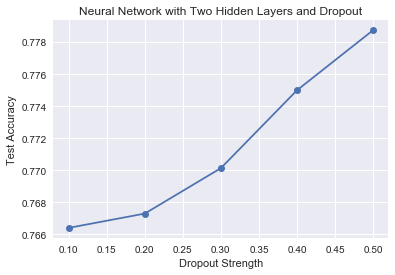

In [50]:
dropOut = [0.1, 0.2, 0.3, 0.4, 0.5]
dropAccuracy = []
for prediction in range(0,len(modelPredictions)):
    dropAccuracy.append(accuracy_score(modelPredictions[prediction], y_test))

ax7 = plt.plot(dropOut, dropAccuracy, marker = "o")
plt.title("Neural Network with Two Hidden Layers and Dropout")
plt.ylabel("Test Accuracy")
plt.xlabel("Dropout Strength")
plt.savefig("Multi Layer - Dropout - Test Accuracy.png")

In [51]:
for prediction in range(0,len(modelPredictions)):
    print(accuracy_score(modelPredictions[prediction], y_test))
    print(classification_report(modelPredictions[prediction], y_test))
    
dropOut = pd.DataFrame(data={"0.1_DR":modelPredictions[0].ravel(), "0.2_DR":modelPredictions[1].ravel(), 
                                  "0.3_DR":modelPredictions[2].ravel(), "0.4_DR":modelPredictions[3].ravel(), 
                              "0.5_DR":modelPredictions[4].ravel()})
dropOut.to_csv("gridSearchPredictions_dropOutTwoLayers.csv")

0.766408309711
             precision    recall  f1-score   support

          0       0.92      0.83      0.87     41661
          1       0.41      0.52      0.46      6189
          2       0.21      0.33      0.26      1951
          3       0.03      0.11      0.04       135
          4       0.00      0.00      0.00         0
          5       0.14      0.39      0.21       511

avg / total       0.82      0.77      0.79     50447

0.767300335005
             precision    recall  f1-score   support

          0       0.92      0.83      0.87     41663
          1       0.41      0.52      0.46      6324
          2       0.21      0.35      0.26      1820
          3       0.02      0.12      0.04       112
          4       0.00      0.00      0.00         0
          5       0.15      0.39      0.22       528

avg / total       0.82      0.77      0.79     50447

0.770134993161
             precision    recall  f1-score   support

          0       0.93      0.83      0.88     

/Users/davidrobison/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Update Grid Search for Second Layer with Fewer Nodes

In [41]:
nodes = [50, 150, 250]
modelPredictions = [1,2,3]


# multi_network.add(layers.Dense(units=500, activation='relu', input_dim = 2546))

for nodeCount in range(0,len(nodes)):
    multiNet = models.Sequential()
    multiNet.add(layers.Dense(units = 700, activation = "relu", input_dim = 2546))
    multiNet.add(layers.Dense(units = nodes[nodeCount], activation = "relu"))
    multiNet.add(layers.Dense(units = 6, activation = "softmax"))
    
    multiNet.compile(loss='categorical_crossentropy', # Categorical cross-entropy for multi class output
                optimizer='adam',
                metrics=['categorical_accuracy']) 
    multiNet.fit(X_trainFinal, y_cat_train, epochs = 25, batch_size = 10242)
    
    multiNet.evaluate(X_testFinal, y_test_cat)
    predictionsMultiNet = multiNet.predict_classes(X_testFinal)
    
    modelPredictions[nodeCount] = predictionsMultiNet

In [57]:
highNodes = pd.read_csv("gridSearchPredictions_secondLayer.csv")
highNodes = highNodes.drop("Unnamed: 0", axis = 1)

NewsecondLayer = pd.DataFrame(data={"50_Nodes":modelPredictions[0].ravel(), "150_Nodes":modelPredictions[1].ravel(), 
                                  "250_Nodes":modelPredictions[2].ravel()})
allSecondLayerNodesPreds = pd.concat([NewsecondLayer, highNodes], axis = 1)
allSecondLayerNodesPreds.to_csv("AllSecondLayerNodePreds.csv")

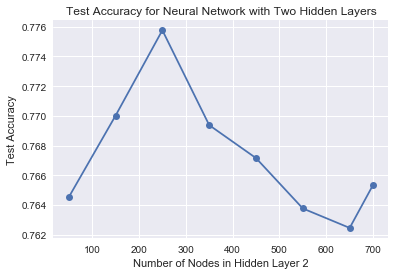

In [58]:
nodes = [50,150,250, 350,450,550,650,700]
nodeAccuray = []
for prediction in range(0,len(allSecondLayerNodesPreds.columns)):
    nodeAccuray.append(accuracy_score(allSecondLayerNodesPreds.iloc[:,prediction], y_test))

ax7 = plt.plot(nodes, nodeAccuray, marker = "o")
plt.title("Test Accuracy for Neural Network with Two Hidden Layers")
plt.ylabel("Test Accuracy")
plt.xlabel("Number of Nodes in Hidden Layer 2")
plt.savefig("All Nodes Multi Layer.png")

In [59]:
for prediction in range(0,len(allSecondLayerNodesPreds.columns)):
    print(accuracy_score(allSecondLayerNodesPreds.iloc[:,prediction], y_test))
    print(classification_report(allSecondLayerNodesPreds.iloc[:,prediction], y_test))

0.764525145202
             precision    recall  f1-score   support

          0       0.92      0.83      0.87     41171
          1       0.42      0.51      0.46      6533
          2       0.23      0.34      0.28      2110
          3       0.03      0.14      0.04       109
          4       0.00      0.00      0.00         0
          5       0.13      0.36      0.20       524

avg / total       0.81      0.76      0.79     50447

0.770016056455
             precision    recall  f1-score   support

          0       0.93      0.83      0.88     42165
          1       0.40      0.53      0.45      5924
          2       0.21      0.37      0.27      1732
          3       0.02      0.09      0.03       109
          4       0.00      0.00      0.00         0
          5       0.14      0.38      0.21       517

avg / total       0.83      0.77      0.80     50447

0.775764663905
             precision    recall  f1-score   support

          0       0.94      0.82      0.88     

/Users/davidrobison/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Final Run: Multi Layer: 700/250.

So far none of these have predicted class 4 once. I'll take my best model on test accuracy and increase the number of epochs to see if through additional forward propogation / back propogation iterations I can improve prediction here. The number of Race == Class 4 is only 57 in the test set and 156 in the train set. These are very subtle assocations for the neural net to learn. 

In [85]:
multiNetFinal = models.Sequential()

#add first layer
multiNetFinal.add(layers.Dense(units=700, activation='relu', input_dim = 2546))
multiNetFinal.add(layers.Dense(units =250, activation = "relu"))

#output layer
multiNetFinal.add(layers.Dense(units = 6, activation = "softmax"))


multiNetFinal.compile(loss='categorical_crossentropy', # Categorical cross-entropy for multi class output
                optimizer='adam',
                metrics=['categorical_accuracy']) 

multiNetFinal.fit(X_trainFinal, y_cat_train, epochs = 50, batch_size = 10242)

In [69]:
multiNetFinal.evaluate(X_testFinal, y_test_cat, batch_size=5000)

50447/50447 [==============================] - 8s 159us/step


[1.4616591506338281, 0.76577396958846033]

In [74]:
multiNetPreds = multiNetFinal.predict_classes(X_testFinal)
print(classification_report(y_test, multiNetPreds))

#             precision    recall  f1-score   support

#           0       0.83      0.91      0.87     37485
#           1       0.51      0.41      0.45      7858
#           2       0.33      0.21      0.26      3072
#           3       0.08      0.04      0.05       580
#           4       0.20      0.02      0.03        57
#           5       0.30      0.16      0.21      1395

# avg / total       0.73      0.76      0.74     50447

50447/50447 [==============================] - 12s 236us/step

In [75]:
print("Accuracy Score:", accuracy_score(y_test, multiNetPreds))
print(confusion_matrix(y_test, multiNetPreds))

Accuracy Score: 0.765773980613
[[34484  2126   589    97    11   178]
 [ 3930  3253   497    60     3   115]
 [ 1730   576   660    32     3    71]
 [  400   103    34    23     0    20]
 [   53     1     2     0     1     0]
 [  832   240    89    23     1   210]]


#### Save Predictions and Models

In [80]:
multiNetFinalPreds = pd.DataFrame(multiNetPreds, columns= ["700/250_Multi"])
multiNetFinalPreds.to_csv("FinalMultiPreds_700_250.csv")
multiNetFinal.save("FinalMulti_700_250.h5")

## Multi Layer 700/250 with DropOut 0.15 5 Epochs

In [98]:
multiNetDropFinal = models.Sequential()

#add first layer
multiNetDropFinal.add(layers.Dense(units=700, activation='relu', input_dim = 2546))
multiNetDropFinal.add(Dropout(rate = 0.15, seed=2))
multiNetDropFinal.add(layers.Dense(units =250, activation = "relu"))

#output layer
multiNetDropFinal.add(layers.Dense(units = 6, activation = "softmax"))


multiNetDropFinal.compile(loss='categorical_crossentropy', # Categorical cross-entropy for multi class output
                optimizer='adam',
                metrics=['categorical_accuracy']) 

multiNetDropFinal.fit(X_trainFinal, y_cat_train, epochs = 50, batch_size = 10242)

#### Evaluate Save and Print Results

In [99]:
print(multiNetDropFinal.metrics_names)
print(multiNetDropFinal.evaluate(X_testFinal, y_test_cat, batch_size=5000))
multiNetDropFinalPreds = multiNetDropFinal.predict_classes(X_testFinal)
print(accuracy_score(y_test, multiNetDropFinalPreds))
print(classification_report(y_test, multiNetDropFinalPreds))
print(confusion_matrix(y_test, multiNetDropFinalPreds))

multiNetDropFinalSave = pd.DataFrame(multiNetDropFinalPreds, columns = ["Multi700_250_Dr_Preds"])
multiNetDropFinalSave.to_csv("Multi700_250_Dr_Preds")


['loss', 'categorical_accuracy']
50447/50447 [==============================] - 8s 150us/step
[1.4692554544319774, 0.76805359646900984]
50447/50447 [==============================] - 14s 271us/step

#### Save Model

In [100]:
multiNetDropFinal.save("MultiNetDropFinal.h5")

## Multi Layer 700/250 with DropOut 0.15 5 Epochs

In [98]:
multiNetDropFinal = models.Sequential()

#add first layer
multiNetDropFinal.add(layers.Dense(units=700, activation='relu', input_dim = 2546))
multiNetDropFinal.add(Dropout(rate = 0.15, seed=2))
multiNetDropFinal.add(layers.Dense(units =250, activation = "relu"))

#output layer
multiNetDropFinal.add(layers.Dense(units = 6, activation = "softmax"))


multiNetDropFinal.compile(loss='categorical_crossentropy', # Categorical cross-entropy for multi class output
                optimizer='adam',
                metrics=['categorical_accuracy']) 

multiNetDropFinal.fit(X_trainFinal, y_cat_train, epochs = 50, batch_size = 10242)

#### Evaluate Save and Print Results

In [99]:
print(multiNetDropFinal.metrics_names)
print(multiNetDropFinal.evaluate(X_testFinal, y_test_cat, batch_size=5000))
multiNetDropFinalPreds = multiNetDropFinal.predict_classes(X_testFinal)
print(accuracy_score(y_test, multiNetDropFinalPreds))
print(classification_report(y_test, multiNetDropFinalPreds))
print(confusion_matrix(y_test, multiNetDropFinalPreds))

multiNetDropFinalSave = pd.DataFrame(multiNetDropFinalPreds, columns = ["Multi700_250_Dr_Preds"])
multiNetDropFinalSave.to_csv("Multi700_250_Dr_Preds")


['loss', 'categorical_accuracy']
50447/50447 [==============================] - 8s 150us/step
[1.4692554544319774, 0.76805359646900984]
50447/50447 [==============================] - 14s 271us/step

#### Save Model

## Multi-Layer 500/500 50 Epochs

In [84]:
Multi500 = models.Sequential()

Multi500.add(layers.Dense(units=500, activation="relu", input_dim = 2546))
Multi500.add(layers.Dense(units=500, activation="relu", input_dim = 2546))

Multi500.add(layers.Dense(units = 6, activation= "softmax"))

Multi500.compile(loss='categorical_crossentropy', # Categorical cross-entropy for multi class output
                optimizer='adam',
                metrics=['categorical_accuracy'])

Multi500.fit(X_trainFinal, y_cat_train, epochs = 50, batch_size = 10242)

In [82]:
print(Multi500.metrics_names)
print(Multi500.evaluate(X_testFinal, y_test_cat))

['loss', 'categorical_accuracy']
50447/50447 [==============================] - 14s 285us/step

In [83]:
predsMulti500 = Multi500.predict_classes(X_testFinal)
multiNet500FinalPreds = pd.DataFrame(predsMulti500, columns= ["500/500_Multi"])
multiNet500FinalPreds.to_csv("FinalMultiPreds_500_500.csv")
Multi500.save("FinalMulti_500_500.h5")
print(classification_report(y_test, predsMulti500))
#              precision    recall  f1-score   support

#           0       0.83      0.91      0.87     37485
#           1       0.50      0.41      0.45      7858
#           2       0.34      0.21      0.26      3072
#           3       0.07      0.03      0.04       580
#           4       0.17      0.05      0.08        57
#           5       0.32      0.15      0.21      1395

# avg / total       0.73      0.76      0.74     50447

50447/50447 [==============================] - 11s 216us/step

In [86]:
print("Accuracy Score:", accuracy_score(y_test, predsMulti500))
print(confusion_matrix(y_test, predsMulti500))

Accuracy Score: 0.758538664341
[[34130  2336   673    99    10   237]
 [ 3974  3268   445    57     5   109]
 [ 1743   564   639    32     2    92]
 [  415   107    32    11     1    14]
 [   45     5     4     0     2     1]
 [  837   230    97    14     1   216]]


## Single Layer 700 Nodes 50 Epochs

In [96]:
single500 = models.Sequential()

#add first layer
single500.add(layers.Dense(units=700, activation='relu', input_dim = 2546))

#output layer; we use softmax to ensure values between 0 and 1 and can be interpreted as predicted probabilities
single500.add(layers.Dense(units = 6, activation='softmax')) #output layer must create one output for each class (6)

single500.compile(loss='categorical_crossentropy', # Categorical cross-entropy for multi class output
                optimizer='adam',
                metrics=['categorical_accuracy']) 

single500.fit(X_trainFinal, y_cat_train, epochs=50, batch_size = 10242) #75 iterations

In [94]:
print(single500.metrics_names)
print(single500.evaluate(X_testFinal, y_test_cat))

['loss', 'categorical_accuracy']
50447/50447 [==============================] - 13s 266us/step

In [95]:
single500Preds = single500.predict_classes(X_testFinal)
print(accuracy_score(single500Preds, y_test))
print(classification_report(single500Preds, y_test))
print(confusion_matrix(single500Preds, y_test))
single500Save = pd.DataFrame(single500Preds, columns = ["500Single_Preds"])
single500Save.to_csv("500SinglePreds")

50447/50447 [==============================] - 12s 246us/step

/Users/davidrobison/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Save Predictions and Models

In [80]:
multiNetFinalPreds = pd.DataFrame(multiNetPreds, columns= ["700/250_Multi"])
multiNetFinalPreds.to_csv("FinalMultiPreds_700_250.csv")
multiNetFinal.save("FinalMulti_700_250.h5")

## Single Layer 700 Nodes Dropout 0.15, 50 Epochs

In [109]:
single500Dr = models.Sequential()

#add first layer
single500Dr.add(layers.Dense(units=700, activation='relu', input_dim = 2546))
single500Dr.add(Dropout(rate=0.15, seed = 3))

#output layer; we use softmax to ensure values between 0 and 1 and can be interpreted as predicted probabilities
single500Dr.add(layers.Dense(units = 6, activation='softmax')) #output layer must create one output for each class (6)

single500Dr.compile(loss='categorical_crossentropy', # Categorical cross-entropy for multi class output
                optimizer='adam',
                metrics=['categorical_accuracy']) 

single500Dr.fit(X_trainFinal, y_cat_train, epochs=50, batch_size = 10242) #75 iterations

In [110]:
print(single500Dr.metrics_names)
print(single500Dr.evaluate(X_testFinal, y_test_cat))

['loss', 'categorical_accuracy']
50447/50447 [==============================] - 13s 260us/step

In [111]:
single500DrPreds = single500Dr.predict_classes(X_testFinal)
print(accuracy_score(single500DrPreds, y_test))
print(classification_report(single500DrPreds, y_test))
print(confusion_matrix(single500DrPreds, y_test))
single500DrSave = pd.DataFrame(single500DrPreds, columns = ["700SingleDr_Preds"])
single500DrSave.to_csv("700SingleDrPreds")

50447/50447 [==============================] - 12s 245us/step

/Users/davidrobison/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Save Model

In [112]:
single500Dr.save("single500Dr.h5")

## Under and Over Sampling 

In [13]:
X_trainFinalResdf = pd.DataFrame(X_trainFinal)
y_trainResdf = pd.DataFrame(y_train.values)

In [16]:
print(y_trainResdf.shape, X_trainFinalResdf.shape)
print(y_trainResdf.index, X_trainFinalResdf.index)

(102420, 1) (102420, 2546)
RangeIndex(start=0, stop=102420, step=1) RangeIndex(start=0, stop=102420, step=1)


In [17]:
df_sparseTrainRes = pd.concat([X_trainFinalResdf, y_trainResdf], axis = 1)
# df_sparseTrainRes.columns = [df_sparse.columns]
df_sparseTrainRes.shape

(102420, 2547)

In [18]:
df_sparseTrainRes.columns = [df_sparse.columns]
df_sparseTrainRes.columns

Index(['AGE', 'DISCWT', 'TOTAL_DISC', 'LOS', 'NDX', 'NPR', 'AMONTH_0',
       'AMONTH_1', 'AMONTH_10', 'AMONTH_11',
       ...
       'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL',
       'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS', 'RACE'],
      dtype='object', length=2547)

In [19]:
dfSparse0 = df_sparseTrainRes[df_sparseTrainRes['RACE']==0]
dfSparse1 = df_sparseTrainRes[df_sparseTrainRes['RACE']==1]
dfSparse2 = df_sparseTrainRes[df_sparseTrainRes['RACE']==2]
dfSparse3 = df_sparseTrainRes[df_sparseTrainRes['RACE']==3]
dfSparse4 = df_sparseTrainRes[df_sparseTrainRes['RACE']==4]
dfSparse5 = df_sparseTrainRes[df_sparseTrainRes['RACE']==5]

In [30]:
dfSparse0Res = dfSparse0.sample(n= 40000, replace = True, random_state= 12)
dfSparse1Res = dfSparse1.sample(n= 25937, replace = True, random_state= 13)
dfSparse2Res = dfSparse2.sample(n= 16158, replace = True, random_state= 14)
dfSparse3Res = dfSparse3.sample(n= 6186, replace = True, random_state= 15)
dfSparse4Res = dfSparse4.sample(n= 5165, replace = True, random_state= 16)
dfSparse5Res = dfSparse5.sample(n= 8983, replace = True, random_state= 17)

concatDfsOthers = [dfSparse0Res, dfSparse1Res, dfSparse2Res,dfSparse3Res,dfSparse4Res,dfSparse5Res]
# dfSparseTrainResFinal = pd.DataFrame(dfSparse0Res)
# for frame in concatDfsOthers:
#     dfSparseTrainResFinal.append(concatDfsOthers[frame])
# dfSparseTrainResFinal.shape

dfSparseTrainResFinal = pd.concat(concatDfsOthers, ignore_index=True)
print(dfSparseTrainResFinal.shape)
print(dfSparseTrainResFinal.RACE.value_counts())

(102429, 2547)
0    40000
1    25937
2    16158
5     8983
3     6186
4     5165
Name: RACE, dtype: int64


In [31]:
from keras.utils.np_utils import to_categorical

dfSparseTrainResFinal = dfSparse0Res.append([dfSparse1Res, dfSparse2Res, dfSparse3Res, dfSparse4Res, dfSparse5Res], ignore_index= True)
dfSparseTrainResFinal.shape

(102429, 2547)

In [33]:
from keras.utils.np_utils import to_categorical

X_trainFinalRes = np.array(dfSparseTrainResFinal.iloc[:,0:2546])
y_trainFinalRes = dfSparseTrainResFinal.RACE.values
y_trainFinalResCat = to_categorical(y_trainFinalRes)
X_trainFinalRes

array([[-0.53846154,  0.26315789, -0.47533589, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.46153846, -0.52631579, -0.44270633, ...,  0.        ,
         0.        ,  0.        ],
       [-1.34615385, -0.36842105, -0.33190979, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.46153846, -0.21052632, -0.77691939, ...,  0.        ,
         0.        ,  0.        ],
       [-0.65384615, -0.57894737,  0.79596929, ...,  0.        ,
         1.        ,  0.        ],
       [-1.11538462,  0.57894737,  0.1762476 , ...,  0.        ,
         0.        ,  0.        ]])

## Compile and Train 

In [42]:
multiNetResFinal = models.Sequential()

#add first layer
multiNetResFinal.add(layers.Dense(units=700, activation='relu', input_dim = 2546))
multiNetResFinal.add(layers.Dense(units =250, activation = "relu"))

#output layer
multiNetResFinal.add(layers.Dense(units = 6, activation = "softmax"))


multiNetResFinal.compile(loss='categorical_crossentropy', # Categorical cross-entropy for multi class output
                optimizer='adam',
                metrics=['categorical_accuracy']) 

multiNetResFinal.fit(X_trainFinalRes, y_trainFinalResCat, epochs = 25, batch_size = 1024)

In [37]:
y_test_cat = to_categorical(y_test)
print(multiNetResFinal.metrics_names)
multiNetResFinal.evaluate(X_testFinal, y_test_cat)

['loss', 'categorical_accuracy']
50447/50447 [==============================] - 13s 263us/step

[1.8582850505729722, 0.72170793109954634]

In [39]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

multiNetResPreds = multiNetResFinal.predict_classes(X_testFinal)
print(accuracy_score(multiNetResPreds, y_test))
print(classification_report(multiNetResPreds, y_test))
print(confusion_matrix(multiNetResPreds, y_test))
multiNetResSave = pd.DataFrame(multiNetResPreds, columns = ["700_250MultiRes_Preds"])
multiNetResSave.to_csv("700250_MultiResPreds")

50447/50447 [==============================] - 11s 218us/step

# Appendix

# EDA of Categorical Variables

RACE  HOSP_REGION
0     0              56852
      2              35931
      1              10531
      3              10470
1     2              14863
      0               7402
      1                811
      3                719
2     0               6886
      2               1085
      3               1075
      1                184
3     2                800
      0                692
      3                217
      1                 57
4     0                 81
      3                 61
      2                 43
      1                 28
5     0               1487
      2               1266
      1                736
      3                590
Name: HOSP_REGION, dtype: int64


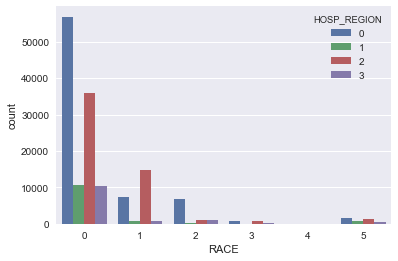

In [39]:
print(df.groupby("RACE")["HOSP_REGION"].value_counts())
sb.countplot(x = df.RACE, hue=df.HOSP_REGION, data=df)

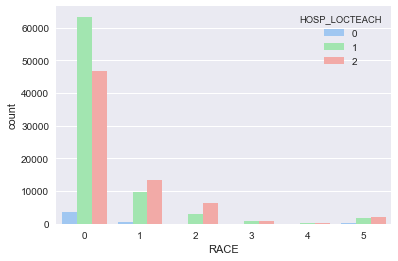

In [108]:
sb.countplot(x = df.RACE, hue=df.HOSP_LOCTEACH, palette= "pastel", color="b")

0    76299
1    15937
2     6158
5     2684
3     1186
4      156
Name: RACE, dtype: int64


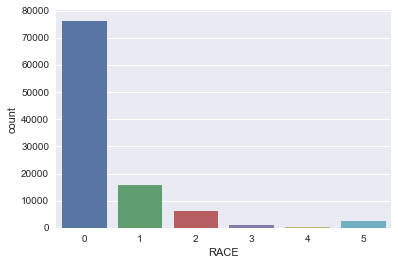

In [32]:
dummy = pd.DataFrame(y_train, columns=["RACE"])
print(dummy.RACE.value_counts())
sb.countplot(dummy.RACE)

In [ ]:
sb.countplot(x = df.RACE, hue=df., palette= "pastel", color="b")

## Correlologram of Features

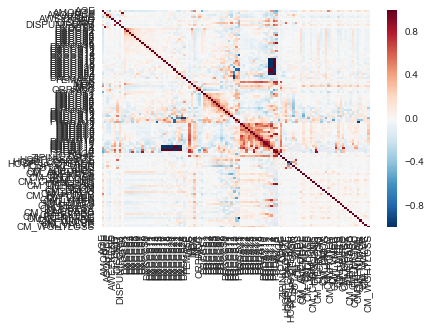

In [93]:
dfCorr = df.corr()
%matplotlib inline
plt.show()
sb.heatmap(dfCorr, )

## Review Disease Diagnosis Code Variables (DXCCS)

Unique Categorical Variables DXCCS1: 230


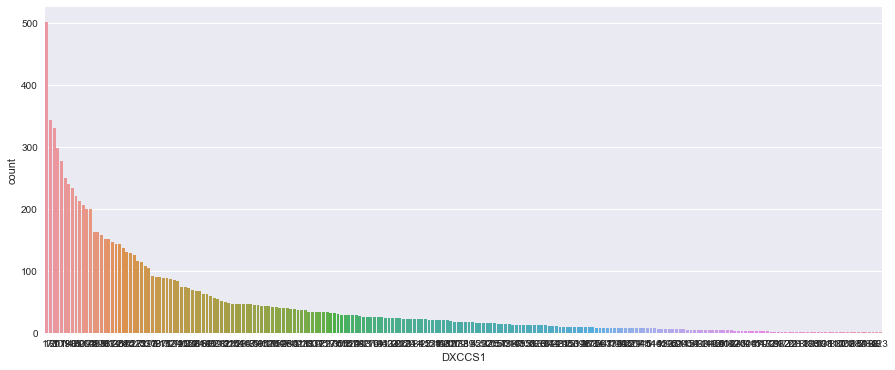

In [34]:
import seaborn as sb
%matplotlib inline
# s = pd.Series(df.loc[:,"DXCCS8"])
# pd.DataFrame(s.value_counts())

f2, ax2 = plt.subplots(figsize = (15,6))
print("Unique Categorical Variables DXCCS1:", len(pd.Series(df.loc[:,"DXCCS1"]).value_counts()))
sb.countplot( x =df.loc[:, "DXCCS1"], order= df["DXCCS1"].value_counts().index)

Unique Categorical Variables: 235


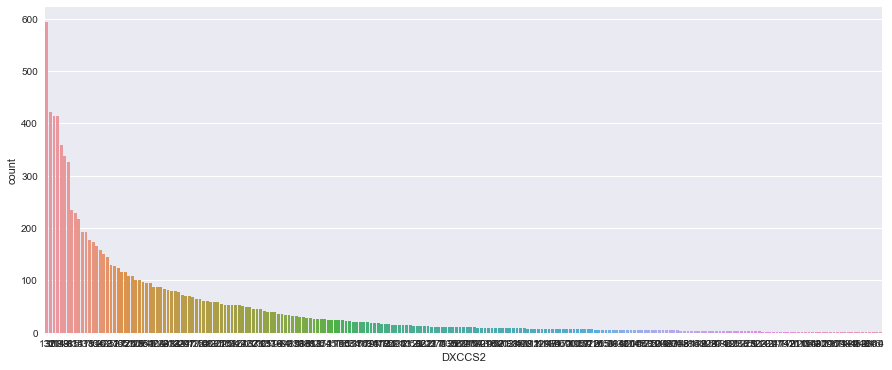

In [33]:
print("Unique Categorical Variables:", len(pd.Series(df.loc[:,"DXCCS2"]).value_counts()))
f2, ax2 = plt.subplots(figsize = (15,6))
sb.countplot( x =df.loc[:, "DXCCS2"], order= df["DXCCS2"].value_counts().index)

Unique Categorical Variables: 237


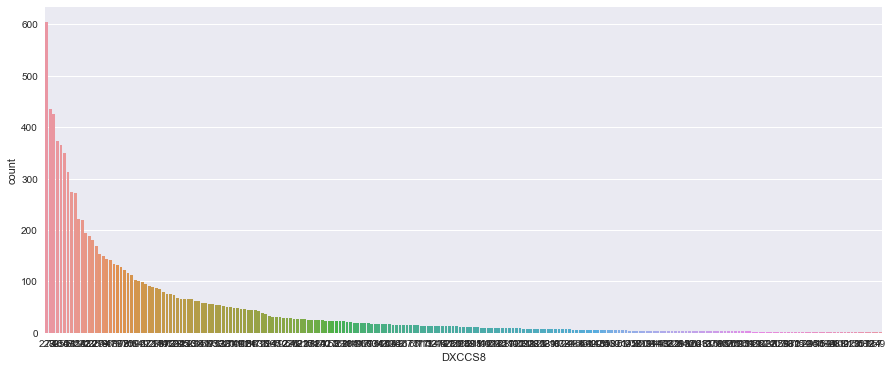

In [32]:
print("Unique Categorical Variables:", len(pd.Series(df.loc[:,"DXCCS8"]).value_counts()))
f8, ax8 = plt.subplots(figsize=(15, 6))
sb.countplot(x = df.loc[:,"DXCCS8"], order= df["DXCCS8"].value_counts().index)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

In [16]:
Xrace = np.array(df.loc[:, df.columns != 'RACE'])
yRace = np.array(df.loc[:,"RACE"])
X_train, X_test, y_train, y_test = train_test_split(Xrace, yRace, test_size = 0.33)

In [19]:
rf = RandomForestClassifier(n_estimators=1000, n_jobs= -1)
rfModel = rf.fit(X_train, y_train)

In [38]:
print("Mean Gini Feature Importance:", np.mean(rfModel.feature_importances_))
print("Number of Features Greater than Mean Feature Importance:",sum(rfModel.feature_importances_ > np.mean(rfModel.feature_importances_)))

Mean Gini Feature Importance: 0.0161290322581
Number of Features Greater than Mean Feature Importance: 22


In [35]:
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(df.loc[:, df.columns != "RACE"].columns, rfModel.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

name                 score
TOTAL_DISC     0.0568823
AGE            0.0543928
ZIPINC_QRTL    0.0513084
TOTCHG         0.0456665
DXCCS8         0.0384664
DXCCS2         0.0376774
DXCCS7         0.0367826
DXCCS6         0.0365866
DXCCS4         0.0364217
DXCCS3         0.0361793
DXCCS5         0.0360802
DXCCS1         0.0360745
LOS            0.0338895
DISCWT         0.0338808
PRCCS1         0.0337471
NDX            0.0287843
MDC            0.0267206
AMONTH         0.0262213
PAY1           0.0221339
NPR            0.0220551
HOSP_REGION    0.0220063
PRDAY1         0.0217245
HOSP_LOCTEACH  0.0152713
DQTR           0.0146958
DISPUNIFORM    0.0134118
HOSP_BEDSIZE   0.0126219
ATYPE          0.0112247
HOSP_CONTROL   0.0101643
ASOURCE        0.00919387
CM_RENLFAIL    0.00859596
CM_ANEMDEF     0.00820625
FEMALE         0.00803932
CM_DM          0.00758933
CM_HTN_C       0.0073191
ORPROC         0.00687352
CM_LYTES       0.00658297
CM_CHRNLUNG    0.00626702
AWEEKEND       0.00601403
CM_OBESE      

In [29]:
names = df.columns
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rfModel.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.056899999999999999, 'HOSP_REGION'), (0.054399999999999997, 'AGE'), (0.051299999999999998, 'TOTCHG'), (0.045699999999999998, 'RACE'), (0.0385, 'DXCCS8'), (0.037699999999999997, 'DXCCS2'), (0.036799999999999999, 'DXCCS7'), (0.036600000000000001, 'DXCCS6'), (0.036400000000000002, 'DXCCS4'), (0.036200000000000003, 'DXCCS3'), (0.0361, 'DXCCS5'), (0.0361, 'DXCCS1'), (0.0339, 'LOS'), (0.0339, 'DISCWT'), (0.033700000000000001, 'PRCCS1'), (0.028799999999999999, 'NDX'), (0.026700000000000002, 'MDC'), (0.026200000000000001, 'AMONTH'), (0.022100000000000002, 'PAY1'), (0.022100000000000002, 'NPR'), (0.021999999999999999, 'HOSP_LOCTEACH'), (0.021700000000000001, 'PRDAY1'), (0.015299999999999999, 'HOSP_CONTROL'), (0.0147, 'DQTR'), (0.0134, 'DISPUNIFORM'), (0.0126, 'ZIPINC_QRTL'), (0.0112, 'ATYPE'), (0.010200000000000001, 'HOSP_BEDSIZE'), (0.0091999999999999998, 'ASOURCE'), (0.0086, 'CM_PULMCIRC'), (0.0082000000000000007, 'CM_ALCOHOL'), (0.0080000000000000002, 'FEMA